In [1]:
# This notebook was adapted from official PyTorch Tutorial
%matplotlib inline

Mount Google Drive first:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# A Gentle Introduction to ``torch.autograd``

``torch.autograd`` is PyTorch’s automatic differentiation engine that powers
neural network training. In this section, you will get a conceptual
understanding of how autograd helps a neural network train.

## Background
Neural networks (NNs) are a collection of nested functions that are
executed on some input data. These functions are defined by *parameters*
(consisting of weights and biases), which in PyTorch are stored in
tensors.

Training a NN happens in two steps:

**Forward Propagation**: In forward prop, the NN makes its best guess
about the correct output. It runs the input data through each of its
functions to make this guess.

**Backward Propagation**: In backprop, the NN adjusts its parameters
proportionate to the error in its guess. It does this by traversing
backwards from the output, collecting the derivatives of the error with
respect to the parameters of the functions (*gradients*), and optimizing
the parameters using gradient descent.

## Usage in PyTorch
Let's take a look at a single training step of a linear regression model.

In this example, We'll create a dataset, define a linear model, and then use Autograd to compute gradients for optimizing our model.

<div class="alert alert-info"><h4>Note</h4><p>This tutorial works only on the CPU and will not work on GPU devices (even if tensors are moved to CUDA).</p></div>

First, we need to import necessary libraries and create a simple dataset.

In [28]:
## Import Necessary Libraries:
import torch
import torch.nn as nn
import torch.optim as optim

## Create a Simple Dataset: For simplicity, we use a small dataset with a linear relationship
# Features (inputs)
x = torch.tensor([[1.0], [2.0], [3.0], [4.0]], requires_grad=True)
# Targets/Labels (outputs)
y = torch.tensor([[2.0], [4.0], [6.0], [8.0]], requires_grad=False)

You may have noticed that we have one more argument **``requires_grad=True``** or **``requires_grad=False``** when we create the two tensors. The ``requires_grad`` attribute in PyTorch is a flag for each tensor that determines whether or not gradients should be computed for operations involving that tensor. When ``requires_grad=True`` is set for a tensor in PyTorch, it indicates that PyTorch should track all operations performed on the tensor and compute gradients with respect to that tensor during the backward pass. Reversely, when you set ``requires_grad=False``, you're telling PyTorch that you don't need gradients for that particular tensor.

Next, we are going to define our simple linear model using ``nn.Linear``.

In [4]:
## Define a Linear Model: We'll use a single linear layer as our model
model = nn.Linear(in_features=1, out_features=1)

We'll define a loss function and optimizer:
- A common choice for linear regression is the Mean Squared Error (MSE) loss.
- We'll use Stochastic Gradient Descent (SGD) as our optimizer, with a learning rate (lr) of 0.01.

In [5]:
# define loss function
criterion = nn.MSELoss()

# define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

Up to now, we have defined all we need for our model. We can run the input data through the model through each of its layers (only one linear layer here) to make a prediction. This is the **forward pass**.

In [6]:
y_pred = model(x)

This is an important step of understanding Autograd in PyTorch. Here, we use the model's prediction and the corresponding label to calculate the error, which is the MSE loss as defined above (``loss``).
Then, we are going to backpropagate this error through the network.
Backward propagation is kicked off when we call **``.backward()``** on the error tensor.
Autograd then calculates and **stores the gradients for each model parameter in the parameter's ``.grad`` attribute.**

In [7]:
# Compute the loss
loss = criterion(y_pred, y)
loss.backward()

Below, we will take a look at the gradients of each parameter.

In [8]:
for param in model.parameters():
  print(param.grad)

tensor([[-28.8808]])
tensor([-9.7734])


Finally, we call ``.step()`` to initiate gradient descent. The optimizer adjusts each parameter by its gradient stored in ``.grad``.

In [9]:
optimizer.step() #gradient descent

At this point, we have everything needed to train your neural network.

Next, let's train the model for 100 epochs. Take a close look at the comments to understand each step.

In [10]:
# Number of epochs (iterations over the dataset)
epochs = 100
for epoch in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute the loss
    loss = criterion(y_pred, y)

    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()  # Clear the gradients of all optimized tensors
    loss.backward()        # Backpropagation to compute gradients
    optimizer.step()       # Update model parameters

    # Optional: Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


Epoch 10/100, Loss: 0.7235443592071533
Epoch 20/100, Loss: 0.02189593017101288
Epoch 30/100, Loss: 0.003557650838047266
Epoch 40/100, Loss: 0.002909100614488125
Epoch 50/100, Loss: 0.0027283576782792807
Epoch 60/100, Loss: 0.00256925355643034
Epoch 70/100, Loss: 0.0024196926970034838
Epoch 80/100, Loss: 0.0022788625210523605
Epoch 90/100, Loss: 0.002146214945241809
Epoch 100/100, Loss: 0.002021300606429577


After training, you can test the model with a new input.

In [11]:
test_x = torch.tensor([[5.0]])
predicted = model(test_x)
print(f"Predicted value for input {test_x.item()}: {predicted.item()}")

Predicted value for input 5.0: 9.923155784606934


In this example, Autograd is used implicitly by PyTorch when ``loss.backward()`` is called. This computes the gradients of the loss with respect to all parameters in the model (which have ``requires_grad=True`` by default in ``nn.Linear``), which are then used by the optimizer to update these parameters.

## Differentiation in Autograd

Ref: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

Let's take a look at how ``autograd`` collects gradients. We create two tensors ``a`` and ``b`` with
``requires_grad=True``. This signals to ``autograd`` that every operation on them should be tracked.




In [12]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

We create another tensor ``Q`` from ``a`` and ``b``.

\begin{align}Q = 3a^3 - b^2\end{align}



In [13]:
Q = 3*a**3 - b**2

Let's assume ``a`` and ``b`` to be parameters of an NN, and ``Q``
to be the error. In NN training, we want gradients of the error
w.r.t. parameters, i.e.

\begin{align}\frac{\partial Q}{\partial a} = 9a^2\end{align}

\begin{align}\frac{\partial Q}{\partial b} = -2b\end{align}


When we call ``.backward()`` on ``Q``, autograd calculates these gradients
and stores them in the respective tensors' ``.grad`` attribute.

We need to explicitly pass a ``gradient`` argument in ``Q.backward()`` because it is a vector.
``gradient`` is a tensor of the same shape as ``Q``, and it represents the
gradient of Q w.r.t. itself, i.e.

\begin{align}\frac{dQ}{dQ} = 1\end{align}

Equivalently, we can also aggregate Q into a scalar and call backward implicitly, like ``Q.sum().backward()``.




In [14]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

Gradients are now deposited in ``a.grad`` and ``b.grad``



In [15]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


## Autograd Example in Lecture

#### Example 1. Basic Gradient Computation

In this example, we'll compute the gradient of a simple function with respect to its input.

In [16]:
# Create a tensor and set requires_grad=True to track computation with it
x = torch.tensor(2.0, requires_grad=True)

# Define a simple function y = x^2
y = x ** 2

# Compute gradients
y.backward()

# Print the gradient dy/dx
print(x.grad)  # Output: tensor(4.0)

tensor(4.)


Here, `y` is defined as $y=x^2$. The gradient computed is $\frac{dy}{dx}$ at $x=2$ is $2x$, which is 4.0

#### Example 2. Partial Derivatives

This example shows computing partial derivatives with respect to multiple inputs using ``torch.autograd`` triggered by ``.backward()`` call.

In [17]:
# Multiple inputs
x = torch.tensor(3.0, requires_grad=True)
w = torch.tensor(6.0, requires_grad=True)
b = torch.tensor(9.0, requires_grad=True)

# Define a function
y = x * w + b # y = 6 * x + 9

# Compute gradients
y.backward()

# Gradients with respect to x, w, and b
print(x.grad)  # Output: tensor(6.0)
print(w.grad)  # Output: tensor(3.0)
print(b.grad)  # Output: tensor(1.0)

tensor(6.)
tensor(3.)
tensor(1.)


#### Example 3. Gradient with Respect to a Vector

Ref: https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

Consider the simplest one-layer neural network, with input ``x``, parameters ``w`` and ``b``, and some loss function. It can be defined in PyTorch in the following manner:

In [18]:
x = torch.ones(5,3)  # input tensor
y = torch.zeros(5)  # expected output
w = torch.randn(3, requires_grad=True)
b = torch.randn(5, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

This code defines the following **computational graph**:


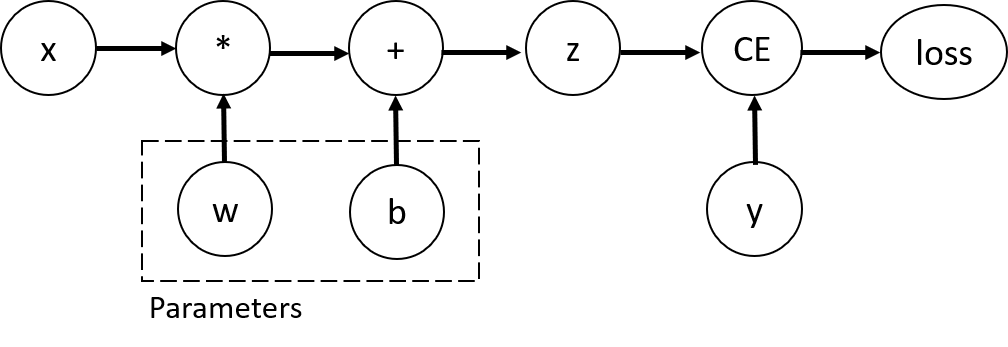

In this network, ``w`` and ``b`` are **parameters**, which we need to
optimize. Thus, we need to be able to compute the gradients of loss
function with respect to those variables. In order to do that, we set
the ``requires_grad`` property of those tensors.

To optimize weights of parameters in the neural network, we need to
compute the derivatives of our loss function with respect to parameters,
namely, we need $\frac{\partial loss}{\partial w}$ and
$\frac{\partial loss}{\partial b}$ under some fixed values of
``x`` and ``y``. To compute those derivatives, we call
``loss.backward()``, and then retrieve the values from ``w.grad`` and
``b.grad``:

In [19]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([0.9321, 0.9321, 0.9321])
tensor([0.1947, 0.1952, 0.1665, 0.1869, 0.1887])


#### Example 4. No Gradient for Non-Scalar Outputs

When the output is not scalar, PyTorch requires a gradient argument in the ``backward`` method, specifying the gradients of the output with respect to some scalar function. For example, if you are going to use ``z`` in previous example as the root of backword pass, e.g.``z.backward``, a gradient argument must be specified within the parentheses of ``backward``. Otherwise, an error will be evoked.

In [20]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x ** 2

# Gradient argument - same shape as y
gradient = torch.tensor([1.0, 1.0, 1.0])
y.backward(gradient)

print(x.grad)  # Output: tensor([2.0, 4.0, 6.0])

tensor([2., 4., 6.])


# Introduction to Optimizers

#### Common Setup

In this step, we define the parameters which the optimizer is going to update during the training process.

In addition, we set up a learning rate of 0.001, a crucial hyperparameter that determines the step size at each iteration while moving towards a minimum of the loss function.

In [21]:
import torch.optim as optim
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-3

Remember to set ``requires_grad=True``, requiring gradients for optimization.

#### SGD Optimizer



In [22]:
optimizer = optim.SGD([params], lr=learning_rate)

#### Adam Optimizer



In [23]:
optimizer = optim.Adam([params], lr=learning_rate)

#### Updating Parameters

In [24]:
optimizer.step()  # Updates 'params' based on gradients and learning rate

The **``step()``** method is a key function that replaces manual parameter updates.

# Introduction to Neural Network Module

In PyTorch the **``torch.nn``** package defines a set of modules which are similar to the layers of a neural network. A module receives input tensors and computes output tensors. The **``torch.nn``** package also defines a set of useful loss functions that are commonly used when training neural networks. This notebook serves as an introduction to the torch.nn module in PyTorch, which provides the necessary tools for building neural networks.

Before we begin, let's import the necessary PyTorch modules.

In [25]:
import torch.nn as nn


## Key Components

There are several key components in the **``torch.nn``** package:
- Layers: Includes various types like Linear (fully connected), Convolutional, and Recurrent layers.
- Activation Functions: Essential non-linearities like ReLU, Sigmoid, and Tanh.
- Loss Functions: Crucial for training, such as Cross-Entropy and Mean Squared Error (MSE).
- Utilities: For tasks like weight initialization and model parameter management.

Each component plays a specific role in the architecture and functionality of a neural network model.

This section introduces each of the key components of torch.nn, demonstrating how to use them in building a neural network.

### 1. Layers

Neural network layers are the building blocks of any model. Here we look at some commonly used layers in **``torch.nn``**.

#### Linear (Fully Connected) Layer

A linear layer, also known as a fully connected layer, is one of the simplest and most commonly used layers.

In [ ]:
# Creating a linear layer with 100 input features and 50 output features
linear_layer = nn.Linear(in_features=100, out_features=50)

#### Convolutional Layer

Convolutional layers are the cornerstone of Convolutional Neural Networks (CNNs), primarily used for image processing.

In [ ]:
# Convolutional layer for image processing, with 3 input channels, 32 output channels, and a kernel size of 5
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)

#### Recurrent Layer (LSTM)

LSTM layers are a type of recurrent neural network layer used for processing sequences and time series data.

In [ ]:
# LSTM layer for sequence processing, with input size 10 and hidden size 20
lstm_layer = nn.LSTM(input_size=10, hidden_size=20)

### 2. Activation Functions

Activation functions introduce non-linear properties to the network, enabling them to learn more complex data patterns.

#### ReLU (Rectified Linear Unit)

ReLU (Rectified Linear Unit) is a widely used activation function, especially in CNNs.


In [ ]:
relu = nn.ReLU()
# Usage: applied to the output of a layer
output = relu(input)

#### Sigmoid Function

The sigmoid function is commonly used in binary classification problems.

In [ ]:
sigmoid = nn.Sigmoid()
# Usage: typically used in binary classification tasks
output = sigmoid(input)

#### Tanh (Hyperbolic Tangent)

Tanh (hyperbolic tangent) is another popular activation function often used in hidden layers.

In [ ]:
tanh = nn.Tanh()
# Usage: often used in hidden layers of a neural network
output = tanh(input)

### 3. Loss Functions

Loss functions evaluate how well the model's predictions match the target values. They are crucial for training neural networks.

#### Cross-Entropy Loss

Used primarily for classification tasks.

In [ ]:
cross_entropy_loss = nn.CrossEntropyLoss()
# Usage: commonly used in multi-class classification tasks
loss = cross_entropy_loss(predictions, targets)

#### Mean Squared Error (MSE) Loss

Often used in regression tasks to measure the average squared difference between predictions and targets.

In [ ]:
mse_loss = nn.MSELoss()
# Usage: frequently used in regression tasks
loss = mse_loss(predictions, targets)

### 4. Utilities

PyTorch provides utilities for tasks like weight initialization and model parameter management.

#### Weight Initialization

In PyTorch, we can set the weights of the layer to be sampled from uniform or normal distribution using the uniform_ and normal_ functions within **``nn.init``** class.

In [ ]:
# Initializing weights of a linear layer with a custom function
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        nn.init.constant_(m.bias, 0)

model = SimpleNet()
model.apply(init_weights)
[(name, param.shape) for name, param in model.named_parameters()]

In [26]:
[(name, param.shape) for name, param in model.named_parameters()]

[('weight', torch.Size([1, 1])), ('bias', torch.Size([1]))]

#### Model Parameter Management

Viewing and managing model parameters is essential for understanding and debugging the model.

In [ ]:
# Viewing the parameters of a model
for param in model.parameters():
    print(param)

Defining the Network

In [35]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [36]:
# Create an instance of the network
model = SimpleNet()

Loss Function and Optimizer

For our training example, let's use Cross-Entropy Loss and the Stochastic Gradient Descent (SGD) optimizer.

In [37]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Generating Random Data

Let's create some random input data and corresponding labels for demonstration purposes. Assuming we are working with flattened images of size 28x28 pixels (which is 784 elements):

In [38]:
# Generating a batch of 5 random inputs and labels
batch_size = 5
input_data = torch.randn(batch_size, 784)  # Random input
labels = torch.randint(0, 10, (batch_size,))  # Random labels for 10 classes

Training Step

Now, let's perform a single training step with this data.

In [39]:
# Zero the gradients
optimizer.zero_grad()

# Forward pass: Compute predicted outputs by passing inputs to the model
predicted_outputs = model(input_data)

# Compute the loss
loss = loss_function(predicted_outputs, labels)

# Backward pass: compute gradient of the loss with respect to model parameters
loss.backward()

# Perform a single optimization step (parameter update)
optimizer.step()

print(f"Loss: {loss.item()}")

Loss: 2.182338237762451


Extend the training process to multiple epoches

In [40]:
# Number of epochs
num_epochs = 30

# Loop over the dataset multiple times
for epoch in range(num_epochs):
    running_loss = 0.0

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(input_data)

    # Calculate the loss
    loss = loss_function(outputs, labels)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Print statistics
    running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss}")

print('Finished Training')


Epoch 1, Loss: 1.9387896060943604
Epoch 2, Loss: 1.721871018409729
Epoch 3, Loss: 1.5288463830947876
Epoch 4, Loss: 1.3570845127105713
Epoch 5, Loss: 1.2006999254226685
Epoch 6, Loss: 1.058062195777893
Epoch 7, Loss: 0.9259008169174194
Epoch 8, Loss: 0.8084060549736023
Epoch 9, Loss: 0.7051030993461609
Epoch 10, Loss: 0.6156116724014282
Epoch 11, Loss: 0.5389310121536255
Epoch 12, Loss: 0.4732646346092224
Epoch 13, Loss: 0.41733837127685547
Epoch 14, Loss: 0.36961182951927185
Epoch 15, Loss: 0.32899096608161926
Epoch 16, Loss: 0.2943427562713623
Epoch 17, Loss: 0.2647152543067932
Epoch 18, Loss: 0.23925228416919708
Epoch 19, Loss: 0.21726855635643005
Epoch 20, Loss: 0.19820347428321838
Epoch 21, Loss: 0.18159647285938263
Epoch 22, Loss: 0.1670655608177185
Epoch 23, Loss: 0.15429317951202393
Epoch 24, Loss: 0.14301139116287231
Epoch 25, Loss: 0.1330145299434662
Epoch 26, Loss: 0.12410982698202133
Epoch 27, Loss: 0.1161460280418396
Epoch 28, Loss: 0.10900115966796875
Epoch 29, Loss: 0.10